# Gaussian Process Regression

Traditional parametrics models such as linear regression or polynomial regression, operate under a crucial assumption that the underlying relationship between the iput and output variables can be adequately captured by a specific functional form characterised by a fixed number of parameters. The learning process focuses on estimating tehse parameters from the observed data. While computationally efficient and interpretable when the assumed form is correct, if the true underlying relationship deviates significantly from the assumed functional form, the model will inevitably produced biased and inaccurate predictions. Nonparametric approach, on the other hand, does not make any assumptions about the model. Rather, we consider every possible function as a candidate model. In other words, we treat the function itself as a random variable. 

GP priors capture our ignorance reading the true generating function $f(x)$. We can view a GP prior as a distribution over possible functions that could have generated the observed data. The number of possible candidate GP prior functions, thus, is infinite. Then, as we observe the data we narrow down our options. Our uncertainty will be high where we lack data and low where we have many data points. But still we have too many options, and it is impossible to consider all of them. Instead, we impose some constraints on our prior distribution of all possible functions. 

The first constraint that arises naturally is smoothness. Suppose we take an arbitrary finite set of input points $x_1, \cdots, x_n$ of size $n$. According to the GP prior, we treat the corresponding function values $y_1, \cdots, y_n$ as random variables and the joint probability distribution of $p(y_1, y_2, \cdots, y_n)$ is a multivariate normal distirbution.

To set up an $n$-variate Gaussian, we need an $n\times n$ covariance matrix. Each element of the matrix determines how much the $(y_i, y_j)$ variables are related. Being smooth means that we use a convariance matrix such that the values that are close in the input space will produce values that are close in the output space.

To calculate the values of the covariance matrix, we use a specialised function called kernel, also known as covariane function. A kernel function is a function that accepts as input two points in the input space $x_i, x_j$ and outputs how "similar" they are based on some notion of distance. For example, consider the following RBF kernel 

$$
k(x, x') = \sigma^2 \exp\left( -\frac{1}{2\ell^2} \| x - x' \| ^2\right)
$$

If $x=x'$, then we have $k(x, x')=\sigma^2$ and if $\|x - x'\|\to\infty$ then we have $k(x,x')\to 0$. The $\ell$ parameter determines the length of the "wiggles". Generally, we are not able to extrapolate more than $\ell$ units away from our data. Similarly, the variance $\sigma^2$ determines the average distance of our function from its mean value. In short, $\ell$ and $\sigma$ circumscribe the horizontal and vertical range of the function.

Given a kernel $k(x, x')$ we construct the covariance matrix with

$$
\begin{align*}
\Sigma(x,x')
=
\begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n)
\\
\vdots & \vdots & \ddots & \vdots
\\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{bmatrix}.
\end{align*}
$$

We also need a mean function $m(x)$ to fully characterise the MVN. Often, for simplicity or lack of prior knowledge, the mean function is set to zero, $m(x)=0$. We then write

$$
y \sim GP(m(x), k(x, x')).
$$

Suppose we have $n_1$ previously observed data points and further observed $n_2$ new testing samples. We then have

$$
\begin{gather*}
Y = \begin{bmatrix} Y_1 \\ Y_2 \end{bmatrix} & \text{with sizes } \begin{bmatrix} n_1 \times 1 \\ n_2 \times 2 \end{bmatrix} 
\\
\mu = \begin{bmatrix}  \mu_1 \\ \mu_2 \end{bmatrix} & \text{with sizes } \begin{bmatrix} n_1 \times 1 \\ n_2 \times 2 \end{bmatrix} 
\\
\Sigma = \begin{bmatrix}  \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} & \text{with sizes } \begin{bmatrix} n_1 \times n_1 & n_1 \times n_2 \\ n_2 \times n_1 & n_2 \times n_2 \end{bmatrix}
\end{gather*}
$$

The distribution of $Y_2$ conditional on $Y_1=y_1$ is $Y_2\mid y_1\sim N(\bar \mu, \bar \Sigma)$ where

$$
\begin{gather*}
\bar \mu = \mu_2 + \Sigma_{21}\Sigma_{11}^{-1}(y_1 - \mu_1)
\\
\bar \Sigma = \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1} \Sigma_{12}
\end{gather*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

In [2]:
# random number generator
random_number_generator = np.random.RandomState(1)

# Create a synthetic dataset
X = np.linspace(0, 10, 1000).reshape(-1, 1)
y = np.squeeze(X*np.sin(X))

# Pick 6 random points from the dataset
training_indices = random_number_generator.choice(np.arange(y.size), size=6, replace=False)

# exact observation
X_train = X[training_indices]
y_train = y[training_indices]

# rbf kernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# constant kernel * rbf kernel
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer=9)
gpr.fit(X_train, y_train)

print(f"Kernel used for prediction: {gpr.kernel_}")
print(f"log of kernel length scale: {gpr.kernel_.theta[0]:4f}")


Kernel used for prediction: RBF(length_scale=0.687)
log of kernel length scale: -0.376130


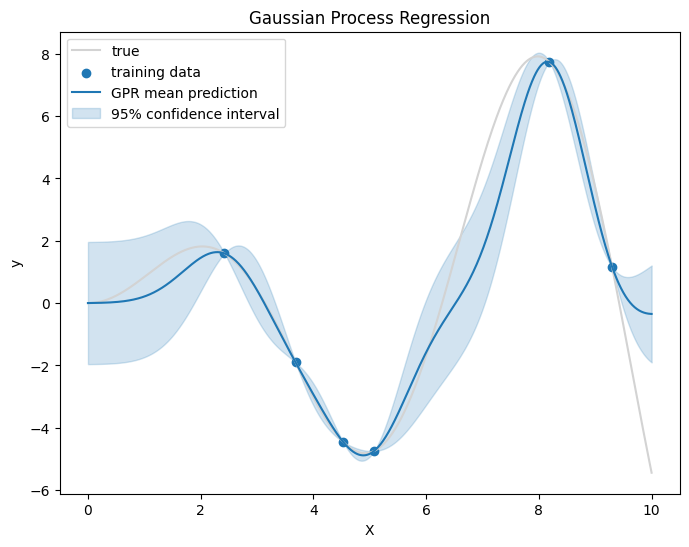

In [3]:
# prediction
y_pred_mean, y_pred_std = gpr.predict(X, return_std=True)

# visualisation of the Gaussian Process Regression result
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X, y, c="lightgray", label="true")
ax.scatter(X_train, y_train, label="training data")
ax.plot(X, y_pred_mean, c="C0", label="GPR mean prediction")
ax.fill_between(
    X.ravel(),
    y_pred_mean - 1.96 * y_pred_std,
    y_pred_mean + 1.96 * y_pred_std,
    alpha=0.2,
    color="C0",
    label=r"95% confidence interval",
)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Gaussian Process Regression")
ax.legend()
plt.show()